In [1]:
# Import libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
# Paths
data_dir = '../data/train'
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)

In [3]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
# Dataset & Dataloader
dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

In [7]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [8]:
# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

C:\Users\shara\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\shara\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [10]:
# Training
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

Epoch [1/5], Loss: 0.1252
Epoch [2/5], Loss: 0.0391
Epoch [3/5], Loss: 0.0204
Epoch [4/5], Loss: 0.0178
Epoch [5/5], Loss: 0.0156


In [22]:
# Evaluation
model.eval()
y_true, y_pred = [], []
y_score = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        # Probability for class "dog" (index 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_score.extend(probs.cpu().numpy())

In [23]:
# Metrics
report = classification_report(y_true, y_pred, target_names=dataset.classes, output_dict=True)
print(report)
with open(os.path.join(results_dir, 'metrics.json'), 'w') as f:
    json.dump(report, f, indent=4)

{'cat': {'precision': 0.9660883280757098, 'recall': 0.9745425616547335, 'f1-score': 0.9702970297029703, 'support': 1257.0}, 'dog': {'precision': 0.974025974025974, 'recall': 0.9654062751407884, 'f1-score': 0.9696969696969697, 'support': 1243.0}, 'accuracy': 0.97, 'macro avg': {'precision': 0.9700571510508419, 'recall': 0.969974418397761, 'f1-score': 0.96999699969997, 'support': 2500.0}, 'weighted avg': {'precision': 0.9700349256421812, 'recall': 0.97, 'f1-score': 0.9699986798679867, 'support': 2500.0}}


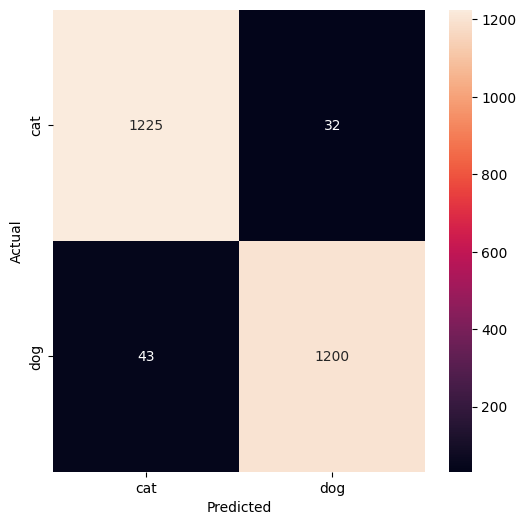

In [24]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(os.path.join(results_dir, 'confusion_matrix.png'))
plt.show()

In [27]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
roc_auc = auc(fpr, tpr)

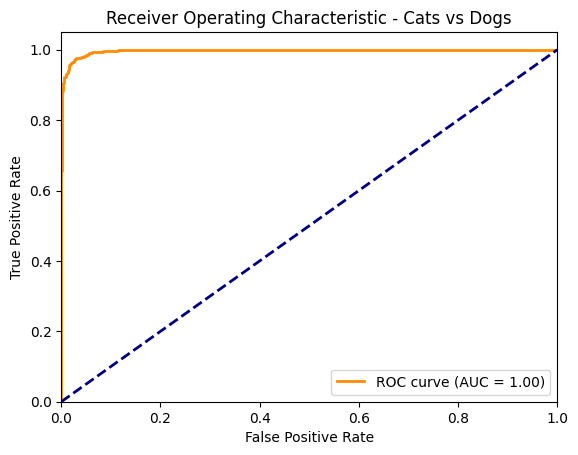

ROC curve saved to ../results/roc_curve.png


In [31]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - Cats vs Dogs")
plt.legend(loc="lower right")

# Save figure
plt.savefig("../results/roc_curve.png")
plt.show()
plt.close()

print("ROC curve saved to ../results/roc_curve.png")

In [32]:
# Save model
torch.save(model.state_dict(), '../models/resnet18_catsdogs.pth')
